# 1. Импорты и загрузка user_features

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

user_features = pd.read_parquet("data/processed/user_features.parquet")
user_features.head()
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138559 entries, 0 to 138558
Data columns (total 22 columns):
 #   Column                            Non-Null Count   Dtype              
---  ------                            --------------   -----              
 0   Идентификатор устройства          138559 non-null  int64              
 1   events_total                      138559 non-null  int64              
 2   sessions_total                    138559 non-null  int64              
 3   first_event                       138559 non-null  datetime64[ns, UTC]
 4   last_event                        138559 non-null  datetime64[ns, UTC]
 5   unique_screens                    138559 non-null  int64              
 6   unique_functional                 138559 non-null  int64              
 7   active_days                       138559 non-null  int64              
 8   events_per_day                    138559 non-null  float64            
 9   sessions_per_day                  138559 non-nul

# 2. Выбор признаков для кластеризации

In [3]:
# базовые поведенческие признаки
base_cols = [
    'events_total',
    'sessions_total',
    'active_days',
    'events_per_day',
    'sessions_per_day',
    'unique_screens',
    'unique_functional'
]

# признаки по экранам (screen_...)
screen_cols = [c for c in user_features.columns if c.startswith('screen_')]

behaviour_cols = [c for c in base_cols + screen_cols if c in user_features.columns]

len(behaviour_cols), behaviour_cols[:10]

(15,
 ['events_total',
  'sessions_total',
  'active_days',
  'events_per_day',
  'sessions_per_day',
  'unique_screens',
  'unique_functional',
  'screen_Важное',
  'screen_Еще',
  'screen_Мои баллы'])

# 3. Подготовка матрицы признаков

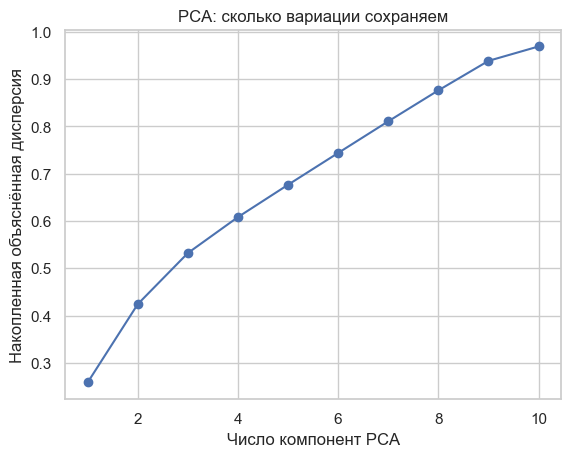

0.9688663547906889

In [8]:
X = user_features[behaviour_cols].copy()

# лог-трансформируем сильно перекошенные счетчики
log_cols = [
    c for c in ['events_total', 'sessions_total', 'active_days',
                'events_per_day', 'sessions_per_day']
    if c in X.columns
]

for col in log_cols:
    X[col] = np.log1p(X[col])

X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA для сжатия измерения
n_features = X_scaled.shape[1]
n_components = min(10, n_features)

pca = PCA(n_components=n_components, random_state=42)
X_pca = pca.fit_transform(X_scaled)

explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(1, n_components + 1), explained_var, marker='o')
plt.xlabel("Число компонент PCA")
plt.ylabel("Накопленная объяснённая дисперсия")
plt.title("PCA: сколько вариации сохраняем")
plt.grid(True)
plt.show()

explained_var[-1]

# 4. KMeans‑кластеризация

n_clusters=3: silhouette=0.2518
n_clusters=4: silhouette=0.2802
n_clusters=5: silhouette=0.3093
n_clusters=6: silhouette=0.3195
n_clusters=7: silhouette=0.3278
n_clusters=8: silhouette=0.2942
n_clusters=9: silhouette=0.3066


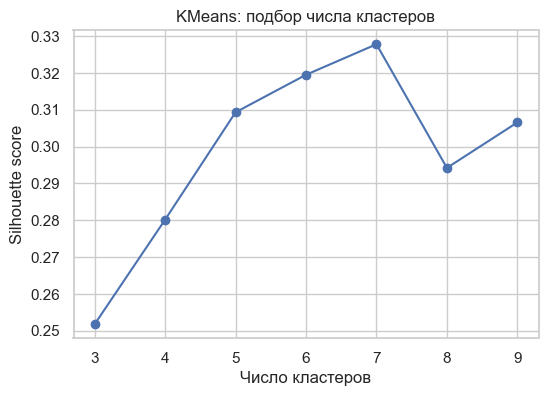

In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

range_n_clusters = [3, 4, 5, 6, 7, 8, 9]
sil_scores_kmeans = {}

for n in range_n_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)
    score = silhouette_score(X_pca, labels)
    sil_scores_kmeans[n] = score
    print(f"n_clusters={n}: silhouette={score:.4f}")

plt.figure(figsize=(6,4))
plt.plot(list(sil_scores_kmeans.keys()), list(sil_scores_kmeans.values()), marker='o')
plt.xlabel("Число кластеров")
plt.ylabel("Silhouette score")
plt.title("KMeans: подбор числа кластеров")
plt.grid(True)
plt.show()

In [10]:
best_k = max(sil_scores_kmeans, key=sil_scores_kmeans.get)
best_k

7

In [11]:
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init='auto')
labels_kmeans = kmeans_final.fit_predict(X_pca)

user_features['cluster_kmeans'] = labels_kmeans
user_features['cluster_kmeans'].value_counts().sort_index()

cluster_kmeans
0    37788
1    11024
2    19273
3    13947
4    37913
5     1550
6    17064
Name: count, dtype: int64

# 5. DBSCAN‑кластеризация

## 5.1. k‑distance plot (для выбора eps)

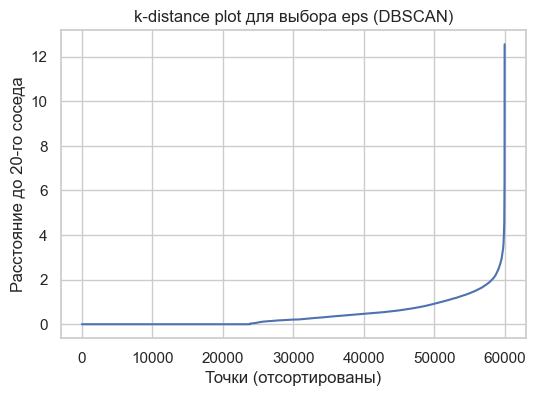

In [13]:
from sklearn.neighbors import NearestNeighbors

# возьмём подвыборку, чтобы было быстрее, 20k пользователей
rng = np.random.default_rng(42)
sample_idx = rng.choice(X_pca.shape[0], size=min(60000, X_pca.shape[0]), replace=False)
X_pca_sample = X_pca[sample_idx]

min_samples = 20  # типичное значение, можно подвинуть

neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(X_pca_sample)
distances, indices = nbrs.kneighbors(X_pca_sample)

# расстояние до min_samples-го соседа
k_distances = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_distances)
plt.ylabel(f"Расстояние до {min_samples}-го соседа")
plt.xlabel("Точки (отсортированы)")
plt.title("k-distance plot для выбора eps (DBSCAN)")
plt.grid(True)
plt.show()

In [18]:
k = np.sort(distances[:, -1])

# ориентиры по процентилям
eps_p90 = np.percentile(k, 90)
eps_p95 = np.percentile(k, 95)
eps_p97 = np.percentile(k, 97)

print("eps_p90:", eps_p90, "eps_p95:", eps_p95, "eps_p97:", eps_p97)


eps_p90: 1.2770885042011213 eps_p95: 1.6909220137512475 eps_p97: 1.9962747586758196


## 5.2. Запуск DBSCAN

In [23]:
from sklearn.cluster import DBSCAN

eps_guess = 1.69
min_samples = 20

dbscan = DBSCAN(eps=eps_guess, min_samples=min_samples)
labels_dbscan = dbscan.fit_predict(X_pca)

user_features['cluster_dbscan'] = labels_dbscan

# -1 = шум
n_noise = (labels_dbscan == -1).sum()
n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)

print("DBSCAN: кластеров (без шума):", n_clusters_db)
print("Доля шума:", n_noise / len(labels_dbscan) * 100, "%")

DBSCAN: кластеров (без шума): 7
Доля шума: 1.3755872949429486 %


## 5.3. Silhouette для DBSCAN (по точкам без шума)

In [24]:
from sklearn.metrics import silhouette_score

mask_not_noise = labels_dbscan != -1

if mask_not_noise.sum() > 1 and n_clusters_db > 1:
    sil_db = silhouette_score(X_pca[mask_not_noise], labels_dbscan[mask_not_noise])
    print("DBSCAN silhouette (без шума):", sil_db)
else:
    print("DBSCAN: слишком мало кластеров или все шум.")

DBSCAN silhouette (без шума): 0.5988442636069964


# 6. Сравнение и профили кластеров

In [25]:
def profile_clusters(df, cluster_col):
    print(f"=== {cluster_col} ===")
    size = df[cluster_col].value_counts(normalize=True).sort_index() * 100
    
    if 'churn_30d' in df.columns:
        churn = df.groupby(cluster_col)['churn_30d'].mean() * 100
    else:
        churn = None
    
    profile = pd.DataFrame({'cluster_size_%': size})
    
    if churn is not None:
        profile['churn_rate_%'] = churn
    
    display(profile)
    return profile


## 6.1. Профиль KMeans‑кластеров

In [26]:
profile_kmeans = profile_clusters(user_features, 'cluster_kmeans')

=== cluster_kmeans ===


,cluster_size_%,churn_rate_%
cluster_kmeans,,
0,27.272137,59.876151
1,7.956178,50.598694
2,13.909598,20.609142
3,10.065748,57.926436
4,27.362351,31.160816
5,1.118657,46.838710
6,12.315331,57.272621


In [27]:
kmeans_means = user_features.groupby('cluster_kmeans')[
    ['events_total', 'sessions_total', 'active_days', 'unique_screens']
].mean()

kmeans_means

,events_total,sessions_total,active_days,unique_screens
cluster_kmeans,,,,
0,3.767545,1.340134,1.219355,1.031121
1,25.806332,1.913915,2.205007,2.053882
2,83.211903,11.401702,18.602605,3.104602
3,6.078081,1.326307,2.519968,1.522980
4,14.856171,5.303458,16.179675,1.604041
5,24.252258,3.522581,7.103226,2.880645
6,19.954407,3.158228,2.023383,2.321496


## 6.2. Профиль DBSCAN‑кластеров

In [28]:
# учитываем только точки не-шум
user_features_non_noise = user_features[user_features['cluster_dbscan'] != -1].copy()

profile_dbscan = profile_clusters(user_features_non_noise, 'cluster_dbscan')

dbscan_means = user_features_non_noise.groupby('cluster_dbscan')[
    ['events_total', 'sessions_total', 'active_days', 'unique_screens']
].mean()

dbscan_means

=== cluster_dbscan ===


,cluster_size_%,churn_rate_%
cluster_dbscan,,
0,99.566054,45.070557
1,0.115621,60.759494
2,0.103913,69.014085
3,0.038053,53.846154
4,0.127330,72.413793
5,0.022685,67.741935
6,0.026344,58.333333


,events_total,sessions_total,active_days,unique_screens
cluster_dbscan,,,,
0,21.489402,4.066596,8.136579,1.759966
1,2.613924,1.025316,1.006329,1.000000
2,4.098592,1.091549,1.042254,1.000000
3,2.346154,1.038462,1.000000,1.000000
4,4.218391,1.132184,1.350575,2.022989
5,10.709677,1.258065,1.193548,2.129032
6,3.888889,1.611111,2.694444,2.000000


KMeans: 7 кластеров, silhouette ≈ 0.33

DBSCAN: 7 кластеров + ~1.4% шума, silhouette (без шума) ≈ 0.60

По KMeans видно сильное различие по оттоку:

* кластер 2: churn ≈ 20%

* кластеры 0, 3, 6: churn ≈ 58–60%

* остальные — между ними.

In [30]:
# cluster  size_%   churn_%
# 0        ~27%     ~60%
# 1        ~8%      ~51%
# 2        ~14%     ~21%
# 3        ~10%     ~58%
# 4        ~27%     ~31%
# 5        ~1%      ~47%
# 6        ~12%     ~57%

Алгоритм KMeans (7 кластеров, silhouette ≈ 0.33) выделил группы пользователей с заметно разной вероятностью оттока.

Кластер 2 (≈14% пользователей) — “наиболее лояльные” пользователи: доля оттока ≈ 21%, что в 2–3 раза ниже, чем у “рисковых” кластеров.

Кластеры 0, 3 и 6 (суммарно ≈ 50% пользователей) имеют долю оттока порядка 58–60% и могут рассматриваться как основная группа риска.

Остальные кластеры демонстрируют промежуточный уровень оттока (31–50%).

# 7 Анализ по KMeans

In [32]:
kmeans_means = user_features.groupby('cluster_kmeans')[
    ['events_total', 'sessions_total', 'active_days', 'unique_screens', 'unique_functional']
].mean()

kmeans_means

,events_total,sessions_total,active_days,unique_screens,unique_functional
cluster_kmeans,,,,,
0,3.767545,1.340134,1.219355,1.031121,1.461284
1,25.806332,1.913915,2.205007,2.053882,4.989931
2,83.211903,11.401702,18.602605,3.104602,8.188346
3,6.078081,1.326307,2.519968,1.522980,1.629454
4,14.856171,5.303458,16.179675,1.604041,2.464590
5,24.252258,3.522581,7.103226,2.880645,5.874839
6,19.954407,3.158228,2.023383,2.321496,3.803563


In [33]:
screen_cols = [c for c in user_features.columns if c.startswith('screen_')]

user_features.groupby('cluster_kmeans')[screen_cols].mean()

,screen_Важное,screen_Еще,screen_Мои баллы,screen_Новая заявка,screen_Новое ОСС,screen_Объявления,screen_Связаться с владельцем ТС,screen_Услуги
cluster_kmeans,,,,,,,,
0,0.005034,0.990657,0.000000,0.003054,0.000000,0.000000,0.000000,0.001255
1,0.027990,0.216155,0.001452,0.655556,0.000978,0.000687,0.001556,0.095627
2,0.057829,0.492533,0.016440,0.394545,0.006467,0.006487,0.002977,0.022722
3,0.793544,0.197072,0.000269,0.003789,0.000675,0.000000,0.000887,0.003766
4,0.106625,0.850164,0.006096,0.024811,0.001972,0.000647,0.003203,0.006482
5,0.060748,0.641162,0.010085,0.021820,0.004667,0.237141,0.004387,0.019988
6,0.149540,0.680418,0.057091,0.029587,0.035899,0.003962,0.029075,0.014310


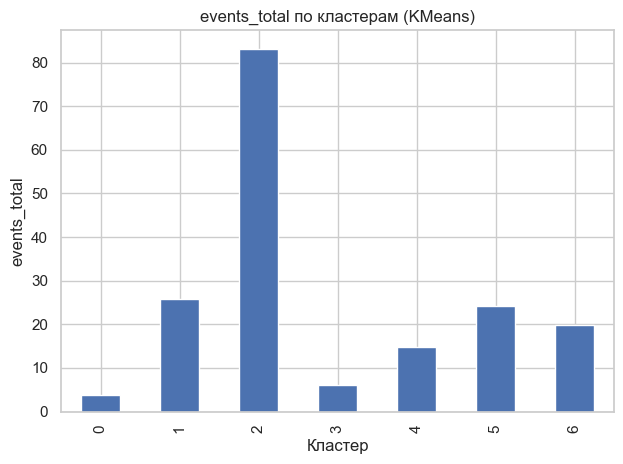

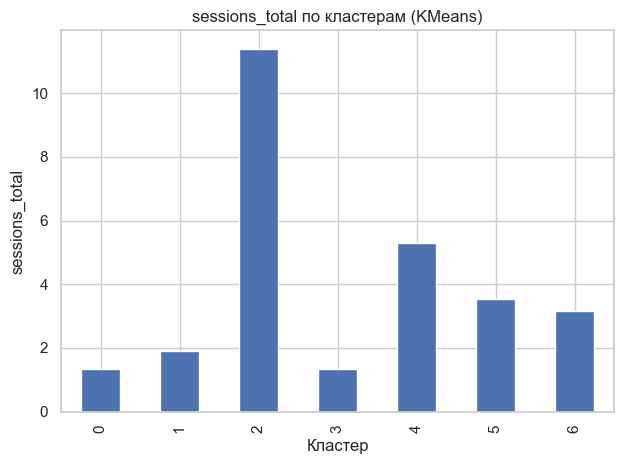

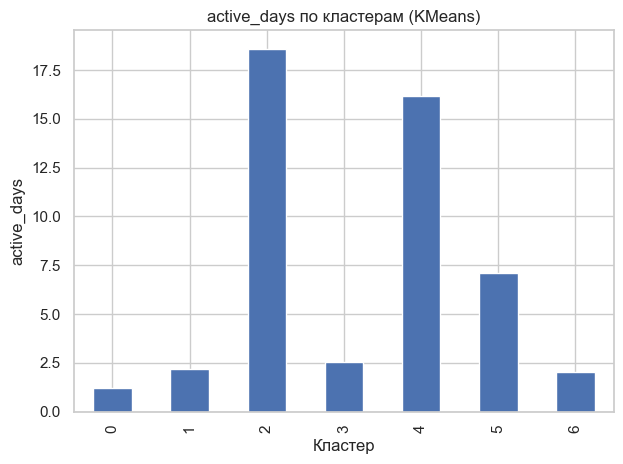

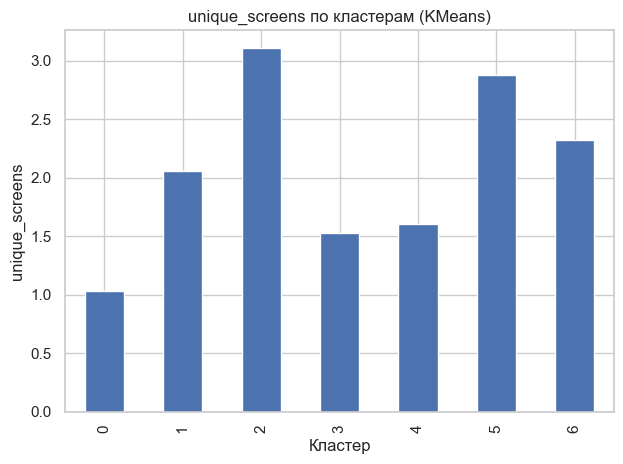

In [34]:
for col in ['events_total', 'sessions_total', 'active_days', 'unique_screens']:
    if col in user_features.columns:
        user_features.groupby('cluster_kmeans')[col].mean().plot(kind='bar')
        plt.title(f"{col} по кластерам (KMeans)")
        plt.xlabel("Кластер")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()


In [35]:
user_features_non_noise = user_features[user_features['cluster_dbscan'] != -1].copy()

profile_dbscan = profile_clusters(user_features_non_noise, 'cluster_dbscan')

dbscan_means = user_features_non_noise.groupby('cluster_dbscan')[
    ['events_total', 'sessions_total', 'active_days', 'unique_screens']
].mean()

profile_dbscan
dbscan_means


=== cluster_dbscan ===


,cluster_size_%,churn_rate_%
cluster_dbscan,,
0,99.566054,45.070557
1,0.115621,60.759494
2,0.103913,69.014085
3,0.038053,53.846154
4,0.127330,72.413793
5,0.022685,67.741935
6,0.026344,58.333333


,events_total,sessions_total,active_days,unique_screens
cluster_dbscan,,,,
0,21.489402,4.066596,8.136579,1.759966
1,2.613924,1.025316,1.006329,1.000000
2,4.098592,1.091549,1.042254,1.000000
3,2.346154,1.038462,1.000000,1.000000
4,4.218391,1.132184,1.350575,2.022989
5,10.709677,1.258065,1.193548,2.129032
6,3.888889,1.611111,2.694444,2.000000


# 8. Визуализация кластеров (KMeans) для слайдов

## 8.1. Scatter по двум PCA‑компонентам

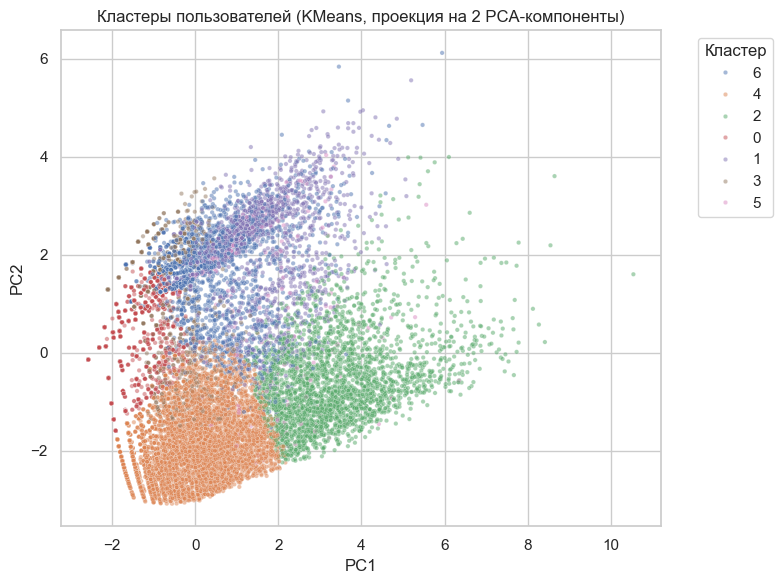

In [36]:
# предполагаю, что X_pca у тебя уже есть из PCA
# если нет — просто переиспользуй тот же код, что был для кластеризации

import matplotlib.pyplot as plt
import seaborn as sns

pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['cluster_kmeans'] = user_features['cluster_kmeans'].astype(str)

# чтобы не рисовать все 180к точек, возьмём сэмпл
sample = pca_df.sample(n=min(20000, len(pca_df)), random_state=42)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=sample,
    x='PC1', y='PC2',
    hue='cluster_kmeans',
    alpha=0.5,
    s=10
)
plt.title("Кластеры пользователей (KMeans, проекция на 2 PCA-компоненты)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title='Кластер', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## 8.2. Теплокарта средних метрик по кластерам

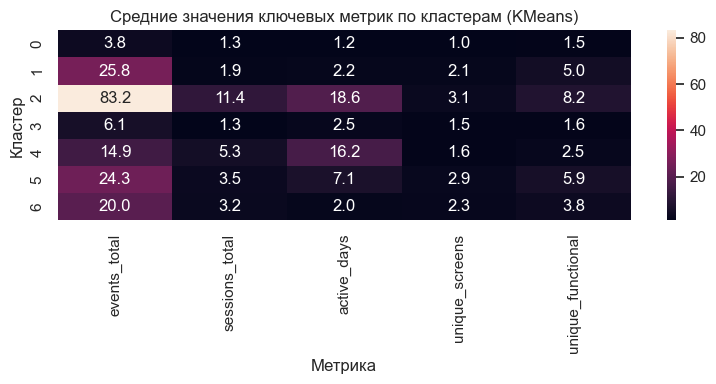

In [37]:
metrics_cols = ['events_total', 'sessions_total', 'active_days',
                'unique_screens', 'unique_functional']

cluster_means = (
    user_features
    .groupby('cluster_kmeans')[metrics_cols]
    .mean()
    .round(1)
)

plt.figure(figsize=(8, 4))
sns.heatmap(cluster_means, annot=True, fmt=".1f")
plt.title("Средние значения ключевых метрик по кластерам (KMeans)")
plt.ylabel("Кластер")
plt.xlabel("Метрика")
plt.tight_layout()
plt.show()


## 8.3. Размер кластера + доля оттока

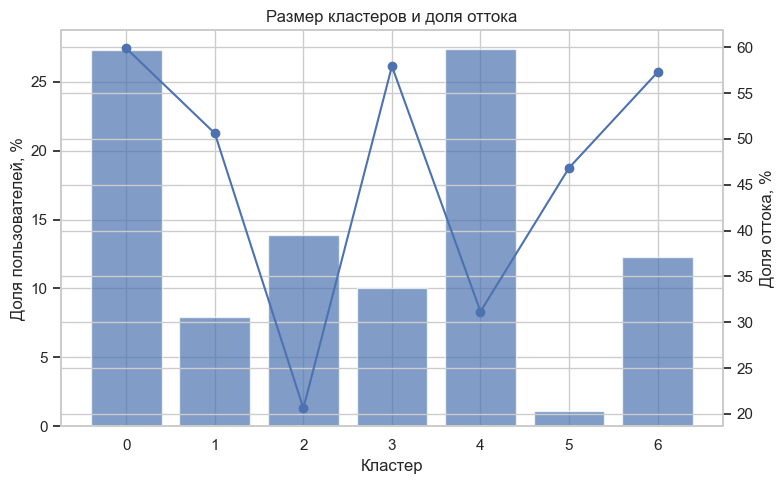

In [38]:
profile_kmeans_reset = profile_kmeans.reset_index()

fig, ax1 = plt.subplots(figsize=(8, 5))

# столбики — размер кластера
ax1.bar(profile_kmeans_reset['cluster_kmeans'],
        profile_kmeans_reset['cluster_size_%'],
        alpha=0.7)
ax1.set_xlabel("Кластер")
ax1.set_ylabel("Доля пользователей, %")

# линия — churn
ax2 = ax1.twinx()
ax2.plot(profile_kmeans_reset['cluster_kmeans'],
         profile_kmeans_reset['churn_rate_%'],
         marker='o')
ax2.set_ylabel("Доля оттока, %")

plt.title("Размер кластеров и доля оттока")
plt.tight_layout()
plt.show()


Кластер 0 — одноразовые/минимальные пользователи

~27% пользователей.

Средние:
events_total ≈ 3.8, sessions_total ≈ 1.3, active_days ≈ 1.2,
unique_screens ≈ 1.0, unique_functional ≈ 1.5.

Отток ≈ 60%.

👉 Интерпретация:
люди заходят в приложение один раз, делают 1–2 действия на одном экране и пропадают. Это “одноразовые посетители”, самый массовый и самый проблемный сегмент.

Кластер 3 — чуть более активные, но всё ещё “слабые”

~10% пользователей.

events_total ≈ 6, sessions_total ≈ 1.3, active_days ≈ 2.5,
экранов и функционалов всё ещё мало.

Отток ≈ 58%.

👉 Это пользователи, которые попробовали приложение 1–2 дня, сделали немного больше действий, чем кластер 0, но всё равно не “зацепились” и тоже массово уходят.

Кластер 6 — интенсивный краткосрочный сценарий

~12% пользователей.

events_total ≈ 20, sessions_total ≈ 3.2, active_days ≈ 2,
unique_screens ≈ 2.3, unique_functional ≈ 3.8.

Отток ≈ 57%.

👉 Пользователи, которые за короткое время делают много действий (несколько сессий, много функционала), но затем перестают пользоваться. Похоже на сценарий “решил одну проблему — сделал пару заявок/операций — и ушёл”.

Кластер 1 — интенсивно пробуют разные функции, но недолго

~8% пользователей.

events_total ≈ 26, sessions_total ≈ 1.9, active_days ≈ 2.2,
unique_screens ≈ 2.0, unique_functional ≈ 5.0.

Отток ≈ 51%.

👉 Пользователи активно щёлкают разные функции (много уникальных функционалов), но всего в 1–2 захода. Похоже, что они исследуют приложение, но не находят достаточной ценности, чтобы остаться.

Кластер 4 — стабильные “рутинные” пользователи

~27% пользователей.

events_total ≈ 14.9, sessions_total ≈ 5.4, active_days ≈ 16.2,
unique_screens ≈ 1.6, unique_functional ≈ 2.5.

Отток ≈ 31%.

👉 Пользователи с длинной жизнью и регулярными заходами, но используют 1–2 ключевые функции (скорее всего, что‑то вроде оплат/заявок/передачи показаний). Это ядро “нормально вовлечённых” — они используют приложение по делу, но без широкого охвата функционала.

Кластер 2 — power‑users / “ядро” лояльных

~14% пользователей.

events_total ≈ 83.2, sessions_total ≈ 11.4, active_days ≈ 18.6,
unique_screens ≈ 3.1, unique_functional ≈ 8.2.

Отток ≈ 21% — самый низкий.

👉 Это суперактивные пользователи: много заходят, живут в приложении долго, используют несколько экранов и максимум функционала. Именно на них, вероятно, приходится основная часть “глубоких” действий (заявки, голосования, гостевой доступ и т.д.). Это главный лояльный сегмент.

Кластер 5 — маленький сегмент умеренно активных

~1% пользователей (очень маленький).

events_total ≈ 24, sessions_total ≈ 3.5, active_days ≈ 7.1,
unique_screens ≈ 2.9, unique_functional ≈ 5.9.

Отток ≈ 47%.

👉 Похоже на промежуточный сегмент между кластерами 1/6 и 4: они живут дольше, чем “одноразовые”, используют больше экранов/функций, но по размеру это очень маленькая группа, поэтому можно не делать на неё отдельный фокус.

# Сохраняем user_features с кластерами

In [39]:
user_features.to_parquet(
    "data/processed/user_features_with_clusters.parquet",
    index=False
)
user_features.to_csv(
    "data/processed/user_features_with_clusters.csv",
    index=False
)